# **Exercício Prático 04 - Boosting com Árvores Rasas**
## Aprendizado de Máquina A
### **Professor(es):** Gisele Lobo Pappa e Lourenço Ribeiro Grossi Araújo
### **Aluno:** Bernardo Reis de Almeida

#### **Imports**

In [3]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#### **Boosting com Árvores Rasas - Gradiente, Estágios e Validação**

##### Leitura dos Dados

In [4]:
# Reading all the data from csv
df = pd.read_csv("dados/dados_boosting.csv")

##### Implementação do Modelo

In [5]:
## Regression tree implementation


class Node:
    def __init__(self, data: pd.DataFrame, depth: int = 0):
        # Shared attributes
        self.type = "Leaf"
        self.depth = depth

        # Leaf node attributes
        self.data = data.copy()
        self.label = np.mean(self.data["y"])

        # Inner node attributes
        self.split = None
        self.left = None
        self.right = None

        # The mse value of the node is kept
        # even if it becomes an inner node
        self.mse = np.mean(np.sum(np.pow(self.data["y"] - np.mean(self.data["y"]), 2)))


class Tree:
    def __init__(
        self,
        max_depth: int = 2,
        n_min: int = 1,
        min_gain: float = 0.0,
    ):
        self.root = None
        self.max_depth = max_depth
        self.n_min = n_min
        self.min_gain = min_gain

    def _split_node(self, node: Node):
        # Does nothing if stopping conditions are met
        if node.depth >= self.max_depth:  # Max depth
            return
        if (sum(node.data["y"]) == 0) or (
            sum(node.data["y"]) == node.data.shape[0]
        ):  # Node purity
            return

        # Finds the best attribute and split point
        _gain = -1
        _split = None
        _attribute = None
        for attribute in node.data.columns[:-2]:

            # Sorts data by the attribute and extract its values
            node.data.sort_values(attribute, inplace=True)
            values = node.data[attribute].to_numpy()

            # Tries all splitting possibilites
            for i in range(node.data.shape[0] - 1):

                # Executes the split
                split = (values[i + 1] + values[i]) / 2
                left = node.data[node.data[attribute] <= split]
                right = node.data[node.data[attribute] > split]

                # Calculates its gain
                mse_left = np.mean(np.sum(np.pow(left["y"] - np.mean(left["y"]), 2)))
                mse_right = np.mean(np.sum(np.pow(right["y"] - np.mean(right["y"]), 2)))
                gain = node.mse - (
                    (left.shape[0] / node.data.shape[0]) * mse_left
                    + (right.shape[0] / node.data.shape[0]) * mse_right
                )

                # Selects it if it is better
                if gain > _gain:
                    _gain = gain
                    _split = split
                    _attribute = attribute

        # Does nothing if stopping conditions are met, part 2
        if (node.data[node.data[_attribute] <= _split].shape[0] < self.n_min) or (
            node.data[node.data[_attribute] > _split].shape[0] < self.n_min
        ):  # Min num of instances per node
            return
        if _gain < self.min_gain:  # Min gain
            return

        # Splits on the best point
        node.split = (_attribute, _split)
        node.left = Node(
            node.data[node.data[_attribute] <= _split],
            node.depth + 1,
        )
        node.right = Node(
            node.data[node.data[_attribute] > _split],
            node.depth + 1,
        )

        # Updates the current node to inner node
        node.type = "Inner"
        node.data = None

        # Continues the splitting on the children
        self._split_node(node.left)
        self._split_node(node.right)

    def fit(self, data):
        if self.root == None:
            self.root = Node(data)
        self._split_node(self.root)

    def predict(self, data):
        result = []

        # Evaluates each instance in data
        for i in range(data.shape[0]):
            x = data.iloc[i]

            # Traverses the tree, looking for the leaf to which x belongs
            curr_node = self.root
            while True:
                if curr_node.type == "Leaf":
                    result.append(curr_node.label)
                    break
                else:
                    attribute, split = curr_node.split
                    if x[attribute] <= split:
                        curr_node = curr_node.left
                    else:
                        curr_node = curr_node.right

        return result

In [6]:
## Gradient boost implementation


class GradientBoost:
    def __init__(
        self, num_trees: int = 10, learning_rate: float = 1.0, max_depth: int = 2
    ):
        # Parameters
        self.M = num_trees
        self.lr = learning_rate
        self.D = max_depth

        # Model
        self.trees = []
        self.start = None

    def fit(self, data):
        # Initialization
        data = data.copy()
        y = data["y"].to_numpy(copy=True)
        self.start = np.mean(y)
        prediction = self.start * np.ones(data.shape[0])

        mses = []
        residuals = []

        # Calculates and registers MSE and residual
        mse = np.mean(np.pow(prediction - y, 2))
        residual = y - prediction
        mses.append(mse)
        residuals.append(residual)

        # Training
        for i in range(self.M):
            # Fits a new tree on this residual
            data["y"] = residual
            tree = Tree(max_depth=self.D)
            tree.fit(data)

            # Adds the new tree to the model
            self.trees.append(tree)
            prediction += self.lr * np.array(tree.predict(data))

            # Recalculates and registers the mse and residual
            mse = np.mean(np.pow(prediction - y, 2))
            residual = y - prediction
            mses.append(mse)
            residuals.append(residual)

        return mses, residuals

    def predict(self, data):
        prediction = self.start * np.ones(data.shape[0])

        # Traverses the trees, summing their predictions
        for i in range(len(self.trees)):
            prediction += self.lr * np.array(self.trees[i].predict(data))

        return prediction

##### Validação Cruzada de Hiperparâmetros

In [7]:
# Parameters
nums_trees = [5, 10, 20]
learning_rates = [0.05, 0.1, 0.2]
max_depths = [1, 2]

n_folds = 4

In [8]:
# Shuffles the database
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

# Train/test separation
split = int(0.7 * df.shape[0])
train = df.iloc[:split].reset_index(drop=True)
test = df.iloc[split:].reset_index(drop=True)

# Fold separation
fold_size = int(train.shape[0] / n_folds)

In [9]:
## K-fold cross validation
print("### K-Fold Cross Validation ###")
print()

# Best values
_mse = 999999
_num_trees = None
_learning_rate = None
_max_depth = None

# All the combinations of parameters
grid = itertools.product(nums_trees, learning_rates, max_depths)

for num_trees, learning_rate, max_depth in grid:

    # Tracks the mse per fold
    train_mse = []
    val_mse = []

    for i in range(n_folds):

        # Generates the fold
        train_fold = pd.concat([train[: i * fold_size], train[(i + 1) * fold_size :]])
        val_fold = train[i * fold_size : (i + 1) * fold_size]

        # Fits the model
        boost = GradientBoost(num_trees, learning_rate, max_depth)
        boost.fit(train_fold)

        # Calculates train and validation mse
        prediction = boost.predict(train_fold)
        train_mse.append(np.mean(np.pow(prediction - train_fold["y"], 2)))

        prediction = boost.predict(val_fold)
        val_mse.append(np.mean(np.pow(prediction - val_fold["y"], 2)))

    # Reports validation accuracy
    avg_train_mse = np.mean(train_mse)
    avg_val_mse = np.mean(val_mse)

    print(
        f"({num_trees}, {learning_rate}, {max_depth}):    Avg. Val. MSE: {avg_val_mse},    Avg. Train MSE: {avg_train_mse}"
    )

    # Updates best parameters if acc is better
    if avg_val_mse < _mse:
        _mse = avg_val_mse
        _num_trees, _learning_rate, _max_depth = num_trees, learning_rate, max_depth

print()
print("### Best Hyperparameters ###")
print("- num_trees:", _num_trees)
print("- learning_rate:", _learning_rate)
print("- max_depth:", _max_depth)

### K-Fold Cross Validation ###

(5, 0.05, 1):    Avg. Val. MSE: 2.6979895882042944,    Avg. Train MSE: 2.6665847350514063
(5, 0.05, 2):    Avg. Val. MSE: 2.501338110793659,    Avg. Train MSE: 2.4514975700938653
(5, 0.1, 1):    Avg. Val. MSE: 2.2986497247086697,    Avg. Train MSE: 2.2572384356829023
(5, 0.1, 2):    Avg. Val. MSE: 1.9803728239154266,    Avg. Train MSE: 1.902838164944714
(5, 0.2, 1):    Avg. Val. MSE: 1.8203037589306592,    Avg. Train MSE: 1.7596859856334799
(5, 0.2, 2):    Avg. Val. MSE: 1.4639663232821873,    Avg. Train MSE: 1.3190946200267282
(10, 0.05, 1):    Avg. Val. MSE: 2.3191265635065226,    Avg. Train MSE: 2.273137687785881
(10, 0.05, 2):    Avg. Val. MSE: 2.0022284482925263,    Avg. Train MSE: 1.9231175329689445
(10, 0.1, 1):    Avg. Val. MSE: 1.8668489656923155,    Avg. Train MSE: 1.7983163885422924
(10, 0.1, 2):    Avg. Val. MSE: 1.491347882402567,    Avg. Train MSE: 1.3525161978033102
(10, 0.2, 1):    Avg. Val. MSE: 1.4102738359591576,    Avg. Train MSE: 1.

##### Treinamento Final com Melhores Hiperparâmetros e Avaliação de Desempenho em Testes

In [10]:
# Adjusting the model with the best hyperparameters
boost = GradientBoost(_num_trees, _learning_rate, _max_depth)
mses, residuals = boost.fit(train)

In [11]:
# Counting attributes used as splits
attribute_usage = {k: 0 for k in [f"x{n}" for n in range(1, 21)]}


def check_att_usage(node: Node):
    if node.type == "Inner":
        attribute_usage[node.split[0]] += 1
        check_att_usage(node.left)
        check_att_usage(node.right)


for tree in boost.trees:
    check_att_usage(tree.root)

# Orders the dict by its values
attribute_usage = dict(sorted(attribute_usage.items(), key=lambda item: item[1]))

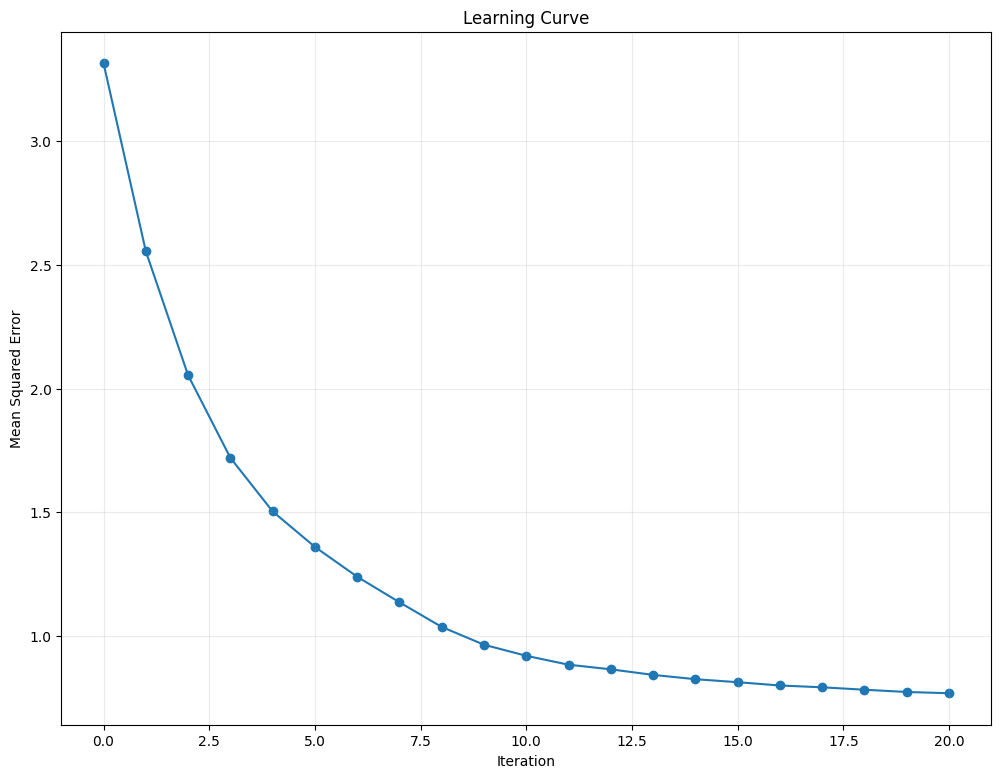

In [12]:
# Plotting the learning curve
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.plot(range(_num_trees + 1), mses)
ax.scatter(range(_num_trees + 1), mses)

ax.grid(alpha=0.25)
ax.set_title("Learning Curve")
ax.set_xlabel("Iteration")
ax.set_ylabel("Mean Squared Error")

plt.show()
plt.close()

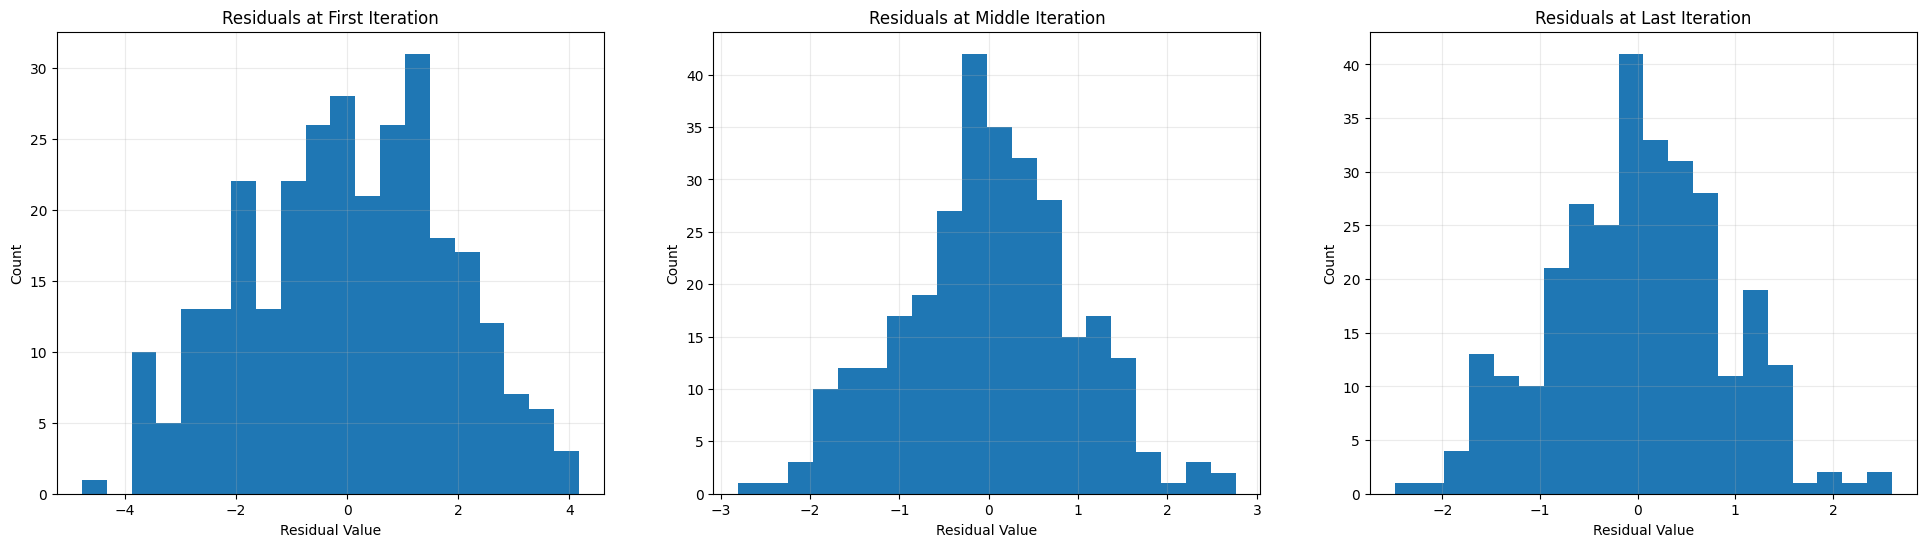

In [16]:
# Plotting the learning curve
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)

ax[0].hist(residuals[0], bins=20)
ax[1].hist(residuals[int(len(residuals) / 2)], bins=20)
ax[2].hist(residuals[-1], bins=20)

ax[0].grid(alpha=0.25)
ax[0].set_title("Residuals at First Iteration")
ax[0].set_xlabel("Residual Value")
ax[0].set_ylabel("Count")

ax[1].grid(alpha=0.25)
ax[1].set_title("Residuals at Middle Iteration")
ax[1].set_xlabel("Residual Value")
ax[1].set_ylabel("Count")

ax[2].grid(alpha=0.25)
ax[2].set_title("Residuals at Last Iteration")
ax[2].set_xlabel("Residual Value")
ax[2].set_ylabel("Count")

plt.show()
plt.close()

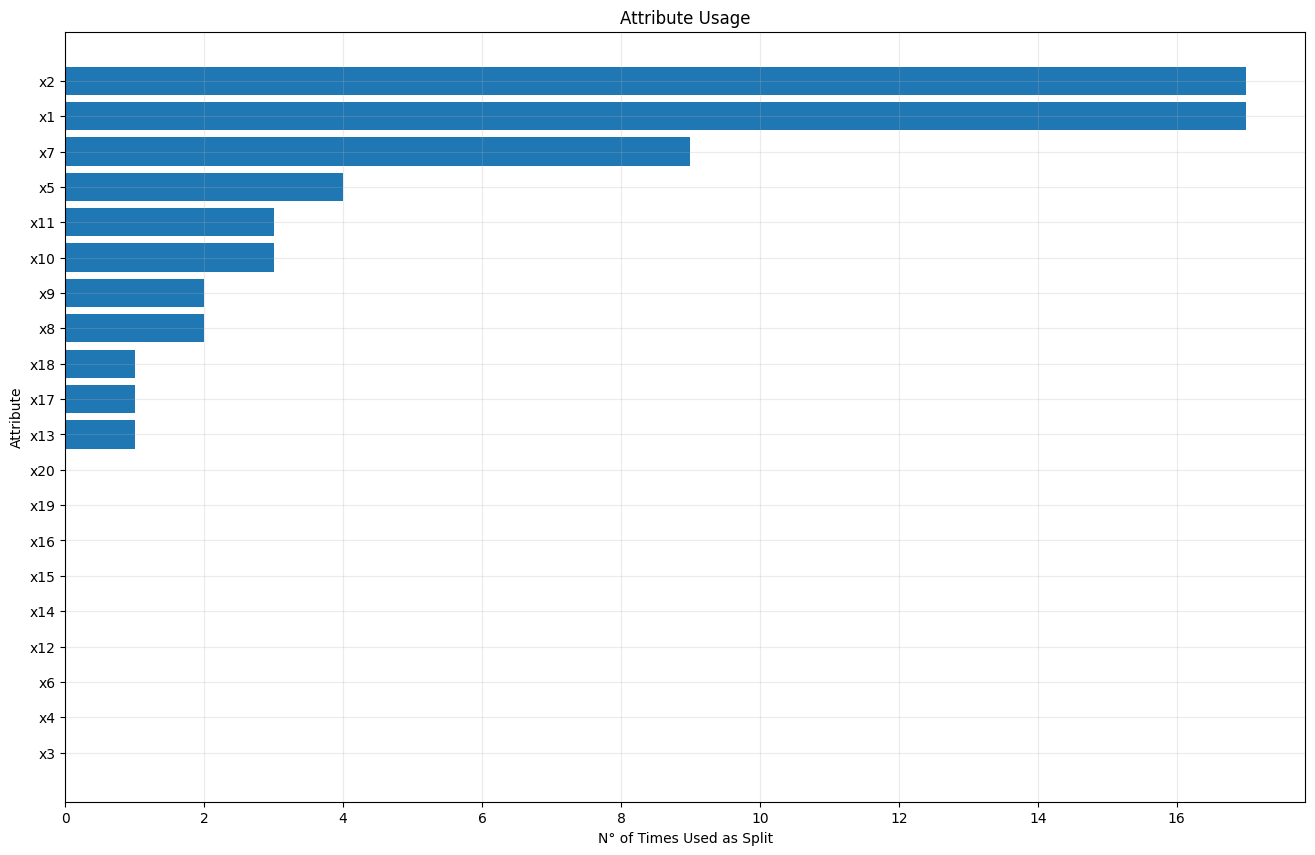

In [14]:
# Plotting the learning curve
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

ax.barh(attribute_usage.keys(), attribute_usage.values())

ax.grid(alpha=0.25)
ax.set_title("Attribute Usage")
ax.set_xlabel("N° of Times Used as Split")
ax.set_ylabel("Attribute")

plt.show()
plt.close()

In [15]:
### Reporting various metrics

## Train
prediction = boost.predict(train)
# MSE
train_mse = np.mean(np.pow(train["y"] - prediction, 2))
# MAE
train_mae = np.mean(np.abs(train["y"] - prediction))
# R2
train_r2 = 1 - (
    np.sum(np.pow((train["y"] - prediction), 2))
    / np.sum(np.pow((train["y"] - np.mean(train["y"])), 2))
)

## Test
prediction = boost.predict(test)
# MSE
test_mse = np.mean(np.pow(test["y"] - prediction, 2))
# MAE
test_mae = np.mean(np.abs(test["y"] - prediction))
# R2
test_r2 = 1 - (
    np.sum(np.pow((test["y"] - prediction), 2))
    / np.sum(np.pow((test["y"] - np.mean(test["y"])), 2))
)

## Display
metrics = pd.DataFrame.from_dict(
    {"Train": [train_mse, train_mae, train_r2], "Test": [test_mse, test_mae, test_r2]},
    columns=["MSE", "MAE", "R^2"],
    orient="index",
)
display(metrics)

,MSE,MAE,R^2
Train,0.768318,0.692407,0.768216
Test,1.158633,0.877879,0.679332


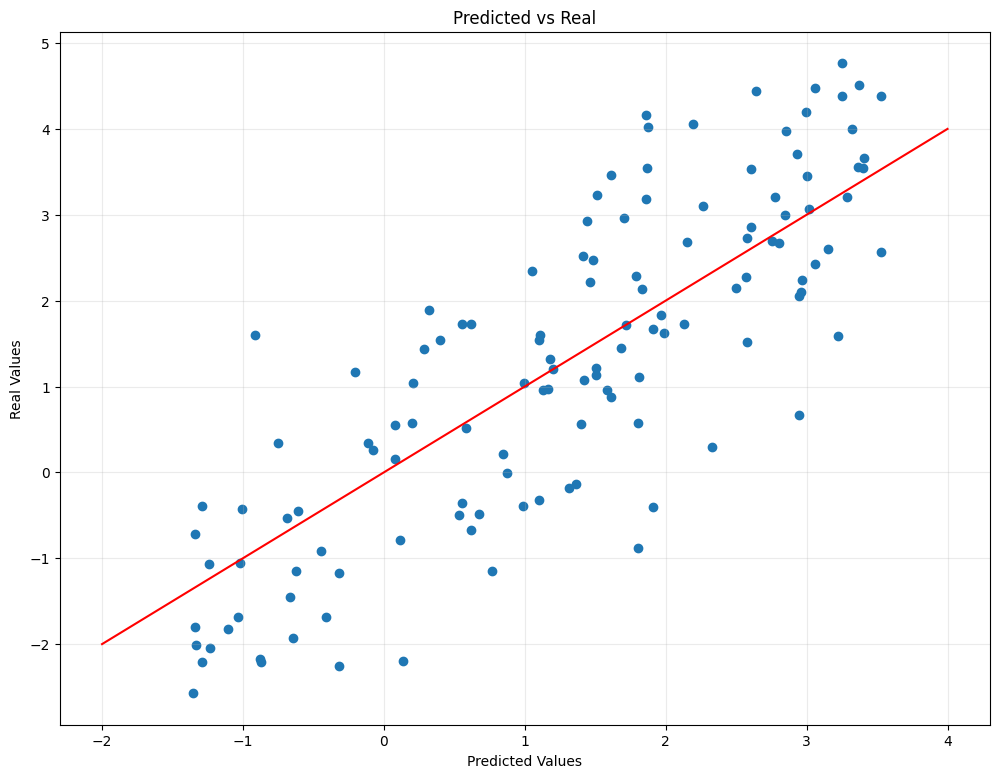

In [21]:
## Plotting a "predicted vs real values" graph
predicted = boost.predict(test)

fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(predicted, test["y"])
ax.plot([-2, 4], [-2, 4], color="red")

ax.grid(alpha=0.25)
ax.set_title("Predicted vs Real")
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Real Values")

plt.show()
plt.close()

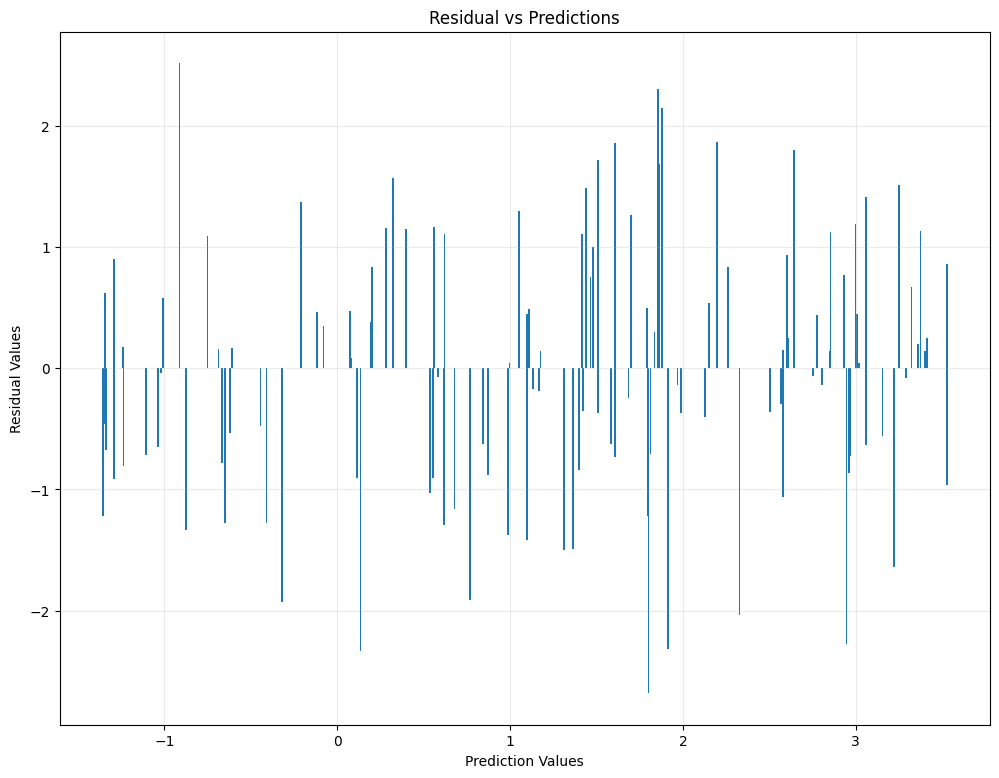

In [38]:
## Plotting a "residual vs predictions" graph
predictions = boost.predict(test)
redisual = test["y"] - predictions

fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.bar(predictions, redisual, width=0.01)

ax.grid(alpha=0.25)
ax.set_title("Residual vs Predictions")
ax.set_xlabel("Prediction Values")
ax.set_ylabel("Residual Values")

plt.show()
plt.close()